# SetUp Environment

In [ ]:
conda create -n scFates -c conda-forge -c r python=3.8 r-mgcv rpy2 -y
conda activate scFates

# Install new jupyter server
conda install -c conda-forge jupyter

# Or add to an existing jupyter server
conda install -c conda-forge ipykernel
python -m ipykernel install --user --name scFates --display-name "scFates"

# Install scFates
pip install scFates

## Required additional packages

In [ ]:
import sys
!{sys.executable} -m pip -q install palantir fa2

# Loading moduels and packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os, sys
# to avoid any possible jupyter crashes due to rpy2 not finding the R install on conda
os.environ['R_HOME'] = sys.exec_prefix+"/lib/R/"
from anndata import AnnData
import numpy as np
import pandas as pd
import scanpy as sc
import scFates as scf
import palantir
import matplotlib.pyplot as plt
sc.settings.verbosity = 3
sc.settings.logfile = sys.stdout

## fix palantir breaking down some plots
import seaborn
seaborn.reset_orig()
%matplotlib inline
sc.set_figure_params()
scf.set_figure_pubready()

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


# Preprocessing pipeline from Palantir

## Load, normalize and log-transform count data

In [2]:
counts = palantir.io.from_csv('https://github.com/dpeerlab/Palantir/raw/master/data/marrow_sample_scseq_counts.csv.gz')

In [3]:
norm_df = sc.pp.normalize_per_cell(counts,copy=True)
norm_df = palantir.preprocess.log_transform(norm_df)

## Perform PCA on highly variable genes

In [4]:
adata=sc.AnnData(norm_df)
sc.pp.highly_variable_genes(adata, n_top_genes=1500, flavor='cell_ranger')
sc.pp.pca(adata)
pca_projections = pd.DataFrame(adata.obsm["X_pca"],index=adata.obs_names)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


## Run Palantir to obtain multiscale diffusion space

In [5]:
dm_res = palantir.utils.run_diffusion_maps(pca_projections)
ms_data = palantir.utils.determine_multiscale_space(dm_res,n_eigs=4)

Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)


## Generate embedding from the multiscale diffusion space

In [6]:
# generate neighbor draph in multiscale diffusion space
adata.obsm["X_palantir"]=ms_data.values
sc.pp.neighbors(adata,n_neighbors=30,use_rep="X_palantir")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [7]:
# draw ForceAtlas2 embedding using 2 first PCs as initial positions
adata.obsm["X_pca2d"]=adata.obsm["X_pca"][:,:2]
sc.tl.draw_graph(adata,init_pos='X_pca2d')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:22)


## Plotting results

In [13]:
import matplotlib as mpl
#mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Liberation Sans', 'Tahoma']

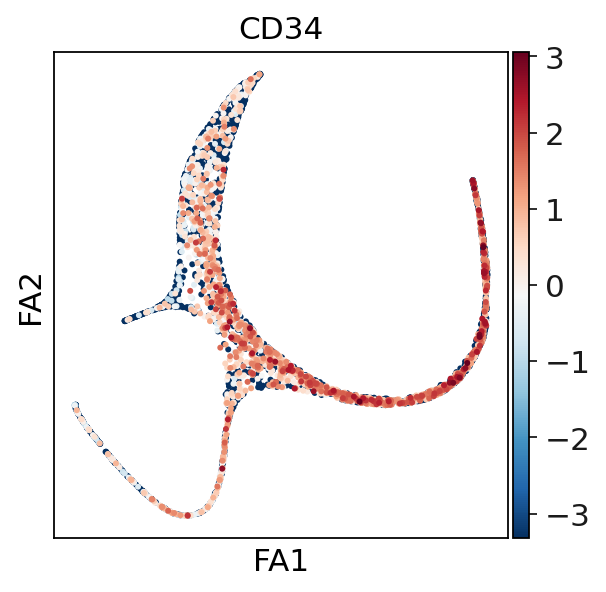

In [14]:
sc.pl.draw_graph(adata,color="CD34",color_map="RdBu_r")

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


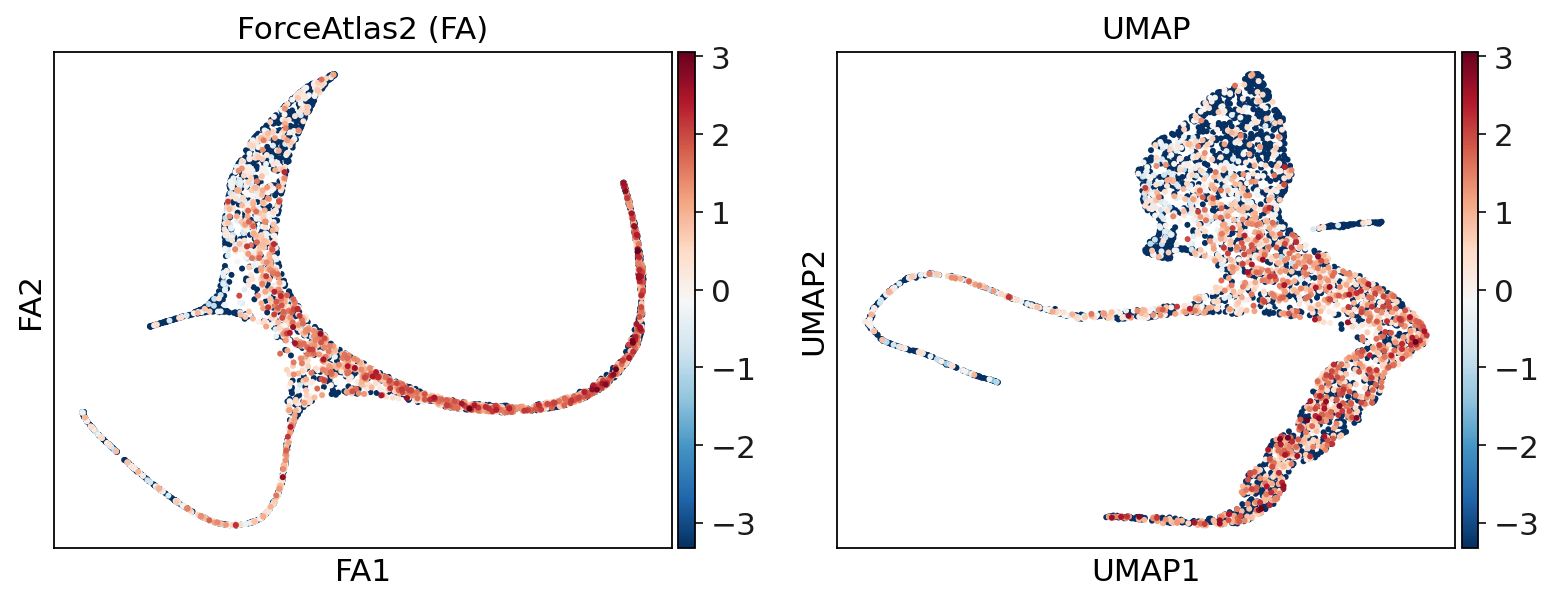

In [15]:
import scanpy as sc
import matplotlib.pyplot as plt

# 1. Compute UMAP on your existing neighbors (X_palantir)
sc.tl.umap(adata, min_dist=0.5)

# 2. Prepare a 1×2 panel
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 3. Left: ForceAtlas2 embedding
sc.pl.draw_graph(
    adata,
    color="CD34",
    color_map="RdBu_r",
    ax=axes[0],
    show=False,
    title="ForceAtlas2 (FA)"
)

# 4. Right: UMAP embedding
sc.pl.umap(
    adata,
    color="CD34",
    color_map="RdBu_r",
    ax=axes[1],
    show=False,
    title="UMAP"
)

plt.tight_layout()
plt.show()


## Save intermediate adata

In [9]:
# make sure your target directory exists
import os
outdir = "/home/job37yv/Projects_shared/Teaching/scFates/data/scFates-bonemarrow"
os.makedirs(outdir, exist_ok=True)

# write the AnnData (including .obsm["X_palantir"], .uns, .obsm["X_draw_graph_fa"], etc.)
adata.write_h5ad(os.path.join(outdir, "bone_marrow_palantir.h5ad"))


In [ ]:
import scanpy as sc
adata = sc.read_h5ad("/home/job37yv/Projects_shared/Teaching/scFates/data/scFates-bonemarrow/bone_marrow_palantir.h5ad")

# sanity check
print(adata)
sc.pl.draw_graph(adata, color="CD34", color_map="RdBu_r")
